Joint Free Energy Surface Analysis
Loading CV arrays for joint analysis...
Loading CHARMM27_TIP3P data...
  Shape: (2500000, 4)
  Subsampled by factor 10
  Converted to Angstroms
  CHARMM27_TIP3P r24-r26: shape (2500000, 2)
  CHARMM27_TIP3P r47-r57: shape (2500000, 2)
Loading CHARMM36m_TIP3P data...
  Shape: (2500000, 4)
  Subsampled by factor 10
  Converted to Angstroms
  CHARMM36m_TIP3P r24-r26: shape (2500000, 2)
  CHARMM36m_TIP3P r47-r57: shape (2500000, 2)

Creating joint distribution plots...

Minima Analysis

CHARMM27:
  r24-r26 pair:
    r24 minimum: 6.05 Å
    r26 minimum: 8.46 Å
  r47-r57 pair:
    r47 minimum: 4.87 Å
    r57 minimum: 6.07 Å

CHARMM36m:
  r24-r26 pair:
    r24 minimum: 5.96 Å
    r26 minimum: 8.43 Å
  r47-r57 pair:
    r47 minimum: 4.72 Å
    r57 minimum: 5.97 Å


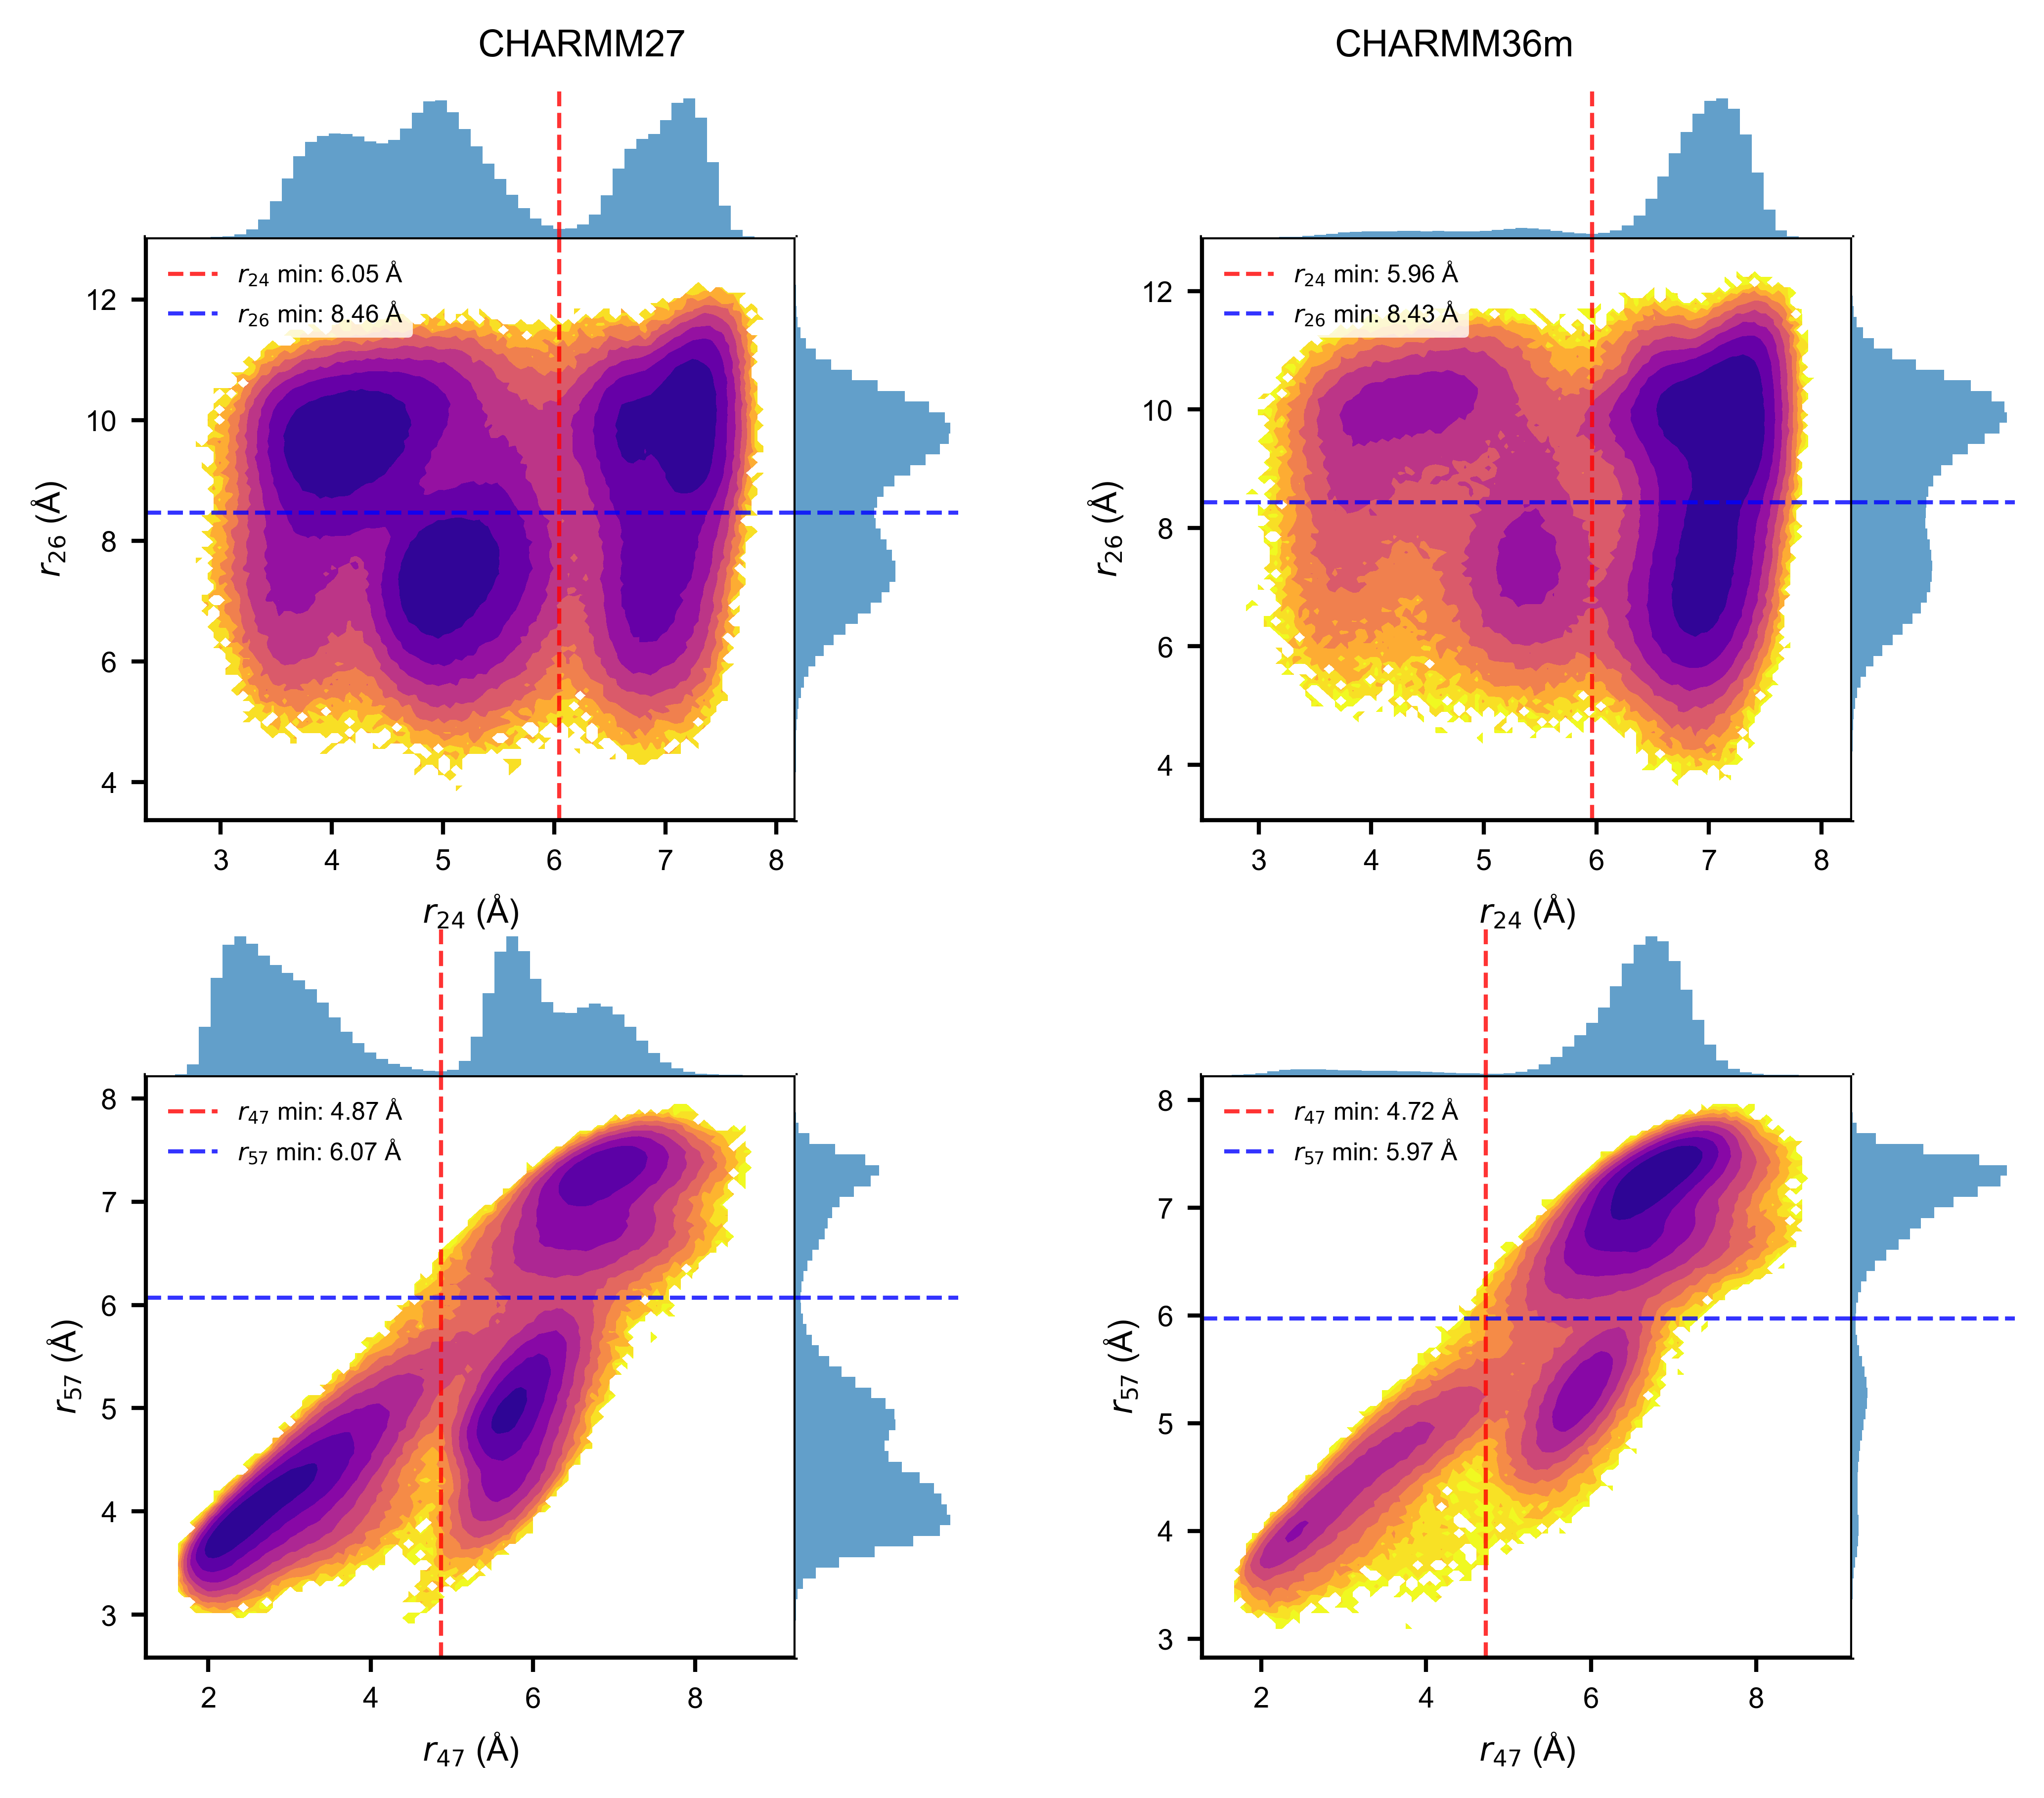


Joint analysis completed successfully!


In [1]:
### PLOTS 2DFES AND MARGINAL HISTOGRAMS FOR 2 MAIN CVs + 2 SECONDARY CVs FOR BOTH FFs (FIG S06) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pyemma.plots as mplt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
PROP_ARRAY_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']
FORCE_FIELD_LABELS = {'CHARMM27_TIP3P': 'CHARMM27', 'CHARMM36m_TIP3P': 'CHARMM36m'}

FEATURE_COLUMNS = {'r24': 0, 'r26': 1, 'r47': 2, 'r57': 3}
FEATURE_PAIRS = [('r24', 'r26'), ('r47', 'r57')]
FEATURE_LABELS = {
    'r24': r'$\mathit{r}_{24}$ (Å)', 
    'r26': r'$\mathit{r}_{26}$ (Å)',
    'r47': r'$\mathit{r}_{47}$ (Å)', 
    'r57': r'$\mathit{r}_{57}$ (Å)'
}

NM_TO_ANGSTROM = 10.0
SUBSAMPLE_RATE = 10 # every 10th frame, so every 200 fs
HIST_BINS = 50

# Minima search ranges (force field specific)
MINIMA_RANGES = {
    'CHARMM27_TIP3P': {
        'r24': (5.0, 7.0), 
        'r26': (8.0, 9.0), 
        'r47': (4.0, 6.0), 
        'r57': (5.0, 7.0)
    },
    'CHARMM36m_TIP3P': {
        'r24': (5.0, 7.0), 
        'r26': (8.3, 8.6), 
        'r47': (4.0, 6.0), 
        'r57': (5.0, 7.0)
    }
}

# Free energy surface parameters (pair specific)
FREE_ENERGY_PARAMS = [
    {'nbins': 100, 'vmin': 0, 'vmax': 8, 'ncontours': 8},   # r24-r26
    {'nbins': 100, 'vmin': 0, 'vmax': 9, 'ncontours': 9}    # r47-r57
]

# Plotting Specifications
FIGURE_SIZE = (7, 6)
DPI = 600
HIST_ALPHA = 0.7

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_cv_array(force_field):
    """Load CV array for specified force field."""
    filepath = PROP_ARRAY_DIR / force_field / f'CV_array_{force_field}.npy'
    
    if not filepath.exists():
        raise FileNotFoundError(f'Missing CV array file: {filepath}')
    
    print(f'Loading {force_field} data...')
    raw_data = np.load(filepath)
    
    # Subsample and convert from nm to Angstrom
    subsampled_data = raw_data[::SUBSAMPLE_RATE]
    converted_data = subsampled_data * NM_TO_ANGSTROM
    
    print(f'  Shape: {converted_data.shape}')
    print(f'  Subsampled by factor {SUBSAMPLE_RATE}')
    print(f'  Converted to Angstroms')
    
    return converted_data

def load_all_data():
    """Load and organize all CV data for analysis."""
    data_dict = {}
    
    print('Loading CV arrays for joint analysis...')
    
    for force_field in FORCE_FIELDS:
        cv_array = load_cv_array(force_field)
        
        # Extract feature pairs
        data_dict[force_field] = {}
        for feature_pair in FEATURE_PAIRS:
            f1, f2 = feature_pair
            
            # Extract columns for this feature pair
            col_indices = [FEATURE_COLUMNS[f1], FEATURE_COLUMNS[f2]]
            pair_data = cv_array[:, col_indices]
            
            data_dict[force_field][feature_pair] = pair_data
            print(f'  {force_field} {f1}-{f2}: shape {pair_data.shape}')
    
    return data_dict

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def find_1d_histogram_minimum(data, feature, force_field):
    """Find minimum of 1D histogram within specified range."""
    histogram, bin_edges = np.histogram(data, bins=HIST_BINS)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Apply range filter
    range_min, range_max = MINIMA_RANGES[force_field][feature]
    mask = (bin_centers >= range_min) & (bin_centers <= range_max)
    
    if not np.any(mask):
        print(f'    Warning: No data in range {range_min}-{range_max} for {feature}')
        return None
    
    # Find minimum within range
    filtered_centers = bin_centers[mask]
    filtered_histogram = histogram[mask]
    minimum_index = np.argmin(filtered_histogram)
    minimum_value = filtered_centers[minimum_index]
    
    return minimum_value

def analyze_and_report_minima(data_dict):
    """Analyze and report minima for all features and force fields."""
    print('\nMinima Analysis')
    print('=' * 50)
    
    for force_field in FORCE_FIELDS:
        print(f'\n{FORCE_FIELD_LABELS[force_field]}:')
        
        for feature_pair in FEATURE_PAIRS:
            f1, f2 = feature_pair
            pair_data = data_dict[force_field][feature_pair]
            
            x_minimum = find_1d_histogram_minimum(pair_data[:, 0], f1, force_field)
            y_minimum = find_1d_histogram_minimum(pair_data[:, 1], f2, force_field)
            
            print(f'  {f1}-{f2} pair:')
            if x_minimum is not None:
                print(f'    {f1} minimum: {x_minimum:.2f} Å')
            else:
                print(f'    {f1} minimum: Not found')
                
            if y_minimum is not None:
                print(f'    {f2} minimum: {y_minimum:.2f} Å')
            else:
                print(f'    {f2} minimum: Not found')

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def style_marginal_axis(ax):
    """Style marginal histogram axes by hiding ticks and spines."""
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_joint_distribution_panel(fig, subplot_spec, data, f1, f2, force_field, fe_params):
    """Create single panel with 2D FES, marginal histograms, and minima markers."""
    # Create sub-grid for joint plot with marginals
    sub_grid = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=subplot_spec,
        height_ratios=[1, 4], width_ratios=[4, 1], 
        wspace=0, hspace=0
    )
    
    # Create axes
    ax_joint = fig.add_subplot(sub_grid[1, 0])      # Main 2D plot
    ax_marginal_x = fig.add_subplot(sub_grid[0, 0], sharex=ax_joint)  # Top marginal
    ax_marginal_y = fig.add_subplot(sub_grid[1, 1], sharey=ax_joint)  # Right marginal
    
    # Plot 2D free energy surface
    mplt.plot_free_energy(
        data[:, 0], data[:, 1], 
        ax=ax_joint, 
        cbar=False, 
        cmap='plasma', 
        **fe_params
    )
    
    # Plot marginal histograms
    ax_marginal_x.hist(data[:, 0], bins=HIST_BINS, alpha=HIST_ALPHA, density=True)
    ax_marginal_y.hist(data[:, 1], bins=HIST_BINS, alpha=HIST_ALPHA, 
                      density=True, orientation='horizontal')
    
    # Find and mark minima
    x_minimum = find_1d_histogram_minimum(data[:, 0], f1, force_field)
    y_minimum = find_1d_histogram_minimum(data[:, 1], f2, force_field)
    
    # Add minimum lines with legend labels
    if x_minimum is not None:
        feature_subscript = f1[1:]  # Extract number from 'r24' -> '24'
        x_label = rf'$\mathit{{r}}_{{{feature_subscript}}}$ min: {x_minimum:.2f} Å'
        ax_joint.axvline(x_minimum, color='red', linestyle='--', 
                        linewidth=1, alpha=0.8, label=x_label)
        ax_marginal_x.axvline(x_minimum, color='red', linestyle='--', 
                             linewidth=1, alpha=0.8)
    
    if y_minimum is not None:
        feature_subscript = f2[1:]  # Extract number from 'r26' -> '26'
        y_label = rf'$\mathit{{r}}_{{{feature_subscript}}}$ min: {y_minimum:.2f} Å'
        ax_joint.axhline(y_minimum, color='blue', linestyle='--', 
                        linewidth=1, alpha=0.8, label=y_label)
        ax_marginal_y.axhline(y_minimum, color='blue', linestyle='--', 
                             linewidth=1, alpha=0.8)
    
    # Format main axis
    ax_joint.set_xlabel(FEATURE_LABELS[f1], fontsize=8)
    ax_joint.set_ylabel(FEATURE_LABELS[f2], fontsize=8)
    ax_joint.tick_params(axis='both', labelsize=7)
    
    # Add legend to main plot
    ax_joint.legend(fontsize=6, loc='upper left', frameon=True, 
                   facecolor='white', edgecolor='none')
    
    # Style marginal axes
    style_marginal_axis(ax_marginal_x)
    style_marginal_axis(ax_marginal_y)

def create_joint_analysis_figure(data_dict):
    """Create complete 2x2 figure with joint distributions for all combinations."""
    fig = plt.figure(figsize=FIGURE_SIZE, dpi=DPI)
    
    # Create outer grid
    outer_grid = gridspec.GridSpec(
        2, 2, figure=fig, 
        hspace=0.15, wspace=0.3,
        top=0.96, bottom=0.08, 
        left=0.08, right=0.98
    )
    
    # Add column titles
    fig.text(0.29, 0.98, FORCE_FIELD_LABELS['CHARMM27_TIP3P'], 
             fontsize=9, ha='center')
    fig.text(0.71, 0.98, FORCE_FIELD_LABELS['CHARMM36m_TIP3P'], 
             fontsize=9, ha='center')
    
    # Define plot positions and parameters
    plot_specifications = [
        (0, 0, 'CHARMM27_TIP3P', 0),   # Top-left: CHARMM27, r24-r26
        (0, 1, 'CHARMM36m_TIP3P', 0),  # Top-right: CHARMM36m, r24-r26
        (1, 0, 'CHARMM27_TIP3P', 1),   # Bottom-left: CHARMM27, r47-r57
        (1, 1, 'CHARMM36m_TIP3P', 1)   # Bottom-right: CHARMM36m, r47-r57
    ]
    
    # Create each panel
    for row, col, force_field, pair_index in plot_specifications:
        feature_pair = FEATURE_PAIRS[pair_index]
        f1, f2 = feature_pair
        
        panel_data = data_dict[force_field][feature_pair]
        fe_params = FREE_ENERGY_PARAMS[pair_index]
        
        plot_joint_distribution_panel(
            fig, outer_grid[row, col], 
            panel_data, f1, f2, force_field, fe_params
        )
    
    return fig

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to run joint free energy surface analysis."""
    set_plot_style()
    
    print('Joint Free Energy Surface Analysis')
    print('=' * 50)
    
    try:
        # Load all data
        data_dict = load_all_data()
        
        # Create joint analysis figure
        print('\nCreating joint distribution plots...')
        fig = create_joint_analysis_figure(data_dict)
        
        # Analyze and report minima
        analyze_and_report_minima(data_dict)
        
        # Display figure
        plt.show()
        
        print('\nJoint analysis completed successfully!')
        print('=' * 50)
        
    except Exception as e:
        print(f'Error during analysis: {e}')
        raise

if __name__ == '__main__':
    main()